In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
df.head()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


# EDA

In [4]:
df.columns

Index(['id', 'temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'voltage', 'current',
       'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure',
       'string_id', 'error_code', 'installation_type', 'efficiency'],
      dtype='object')

In [ ]:
(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non-null  object 
 16  effi

In [6]:
print(df.shape)
print(test.shape)

(20000, 17)
(12000, 16)


In [7]:
df.isnull().sum()

id                       0
temperature           1001
irradiance             987
humidity                 0
panel_age             1011
maintenance_count     1027
soiling_ratio         1010
voltage                993
current                977
module_temperature     978
cloud_coverage        1010
wind_speed               0
pressure                 0
string_id                0
error_code            5912
installation_type     5028
efficiency               0
dtype: int64

In [8]:
test.isna().sum()

id                       0
temperature            582
irradiance             615
humidity                 0
panel_age              607
maintenance_count      609
soiling_ratio          610
voltage                547
current                587
module_temperature     580
cloud_coverage         582
wind_speed               0
pressure                 0
string_id                0
error_code            3611
installation_type     2979
dtype: int64

In [9]:
## drop rows with efficiency 0
df = df[df['efficiency'] != 0]

There are 424 rows with negative irradiance values, which is meaningless. Make them 0.

In [10]:
## number of negative irradiance (sensor errors)
count = 0
for val in df['irradiance']:
    if val < 0:
        count += 1

count

408

In [11]:
#replaces all values less than 0 with 0
df['irradiance'] = df['irradiance'].clip(lower=0)

Handle missing values in error_code and installation_type (turn missing values into new category)

In [ ]:
print(df['error_code'].value_counts())
print(df['installation_type'].value_counts())


error_code
E00    5792
E01    3967
E02    3868
Name: count, dtype: int64
installation_type
tracking     4924
fixed        4839
dual-axis    4740
Name: count, dtype: int64


In [13]:
df['error_code'] = df['error_code'].fillna('missing')
df['installation_type'] = df['installation_type'].fillna('missing')

humidity, wind_speed and pressure are object datatype, convert them to float64 (all three have no missing values)

In [14]:
cols_to_convert = ['humidity', 'wind_speed', 'pressure']

# Remove non-numeric characters if any, then convert to float
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [15]:
df.columns

Index(['id', 'temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'voltage', 'current',
       'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure',
       'string_id', 'error_code', 'installation_type', 'efficiency'],
      dtype='object')

Threshold values for columns: (values must be)

Temperature: less than 70

Irradiance: more than 0 and less than 1200

Voltage: remove values above 75% quantile

Current: remove values above 75% quantile

Module temperature: all ok

Cloud Coverage: less than 100

Wind speed: more than 0

Pressure: all ok

In [ ]:
## apply all the filters mentioned above

# Compute 75th‐percentile cutoffs
q75_voltage = df['voltage'].quantile(0.9)
q75_current = df['current'].quantile(0.9)

# Apply all filters at once
filtered_df = df[
    (df['temperature'] < 70) &
    (df['irradiance'] >= 0) & (df['irradiance'] < 1200) &
    (df['voltage'] <= q75_voltage) &
    (df['current'] <= q75_current) &
    (df['cloud_coverage'] <= 100) &
    (df['wind_speed'] >= 0)
].copy()

# (Optional) Reset index if you like
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.shape

(12073, 17)

Impute all numerical missing values with median

In [17]:
filtered_df[filtered_df.select_dtypes(include='number').columns] = filtered_df.select_dtypes(include='number').fillna(filtered_df.median(numeric_only=True))

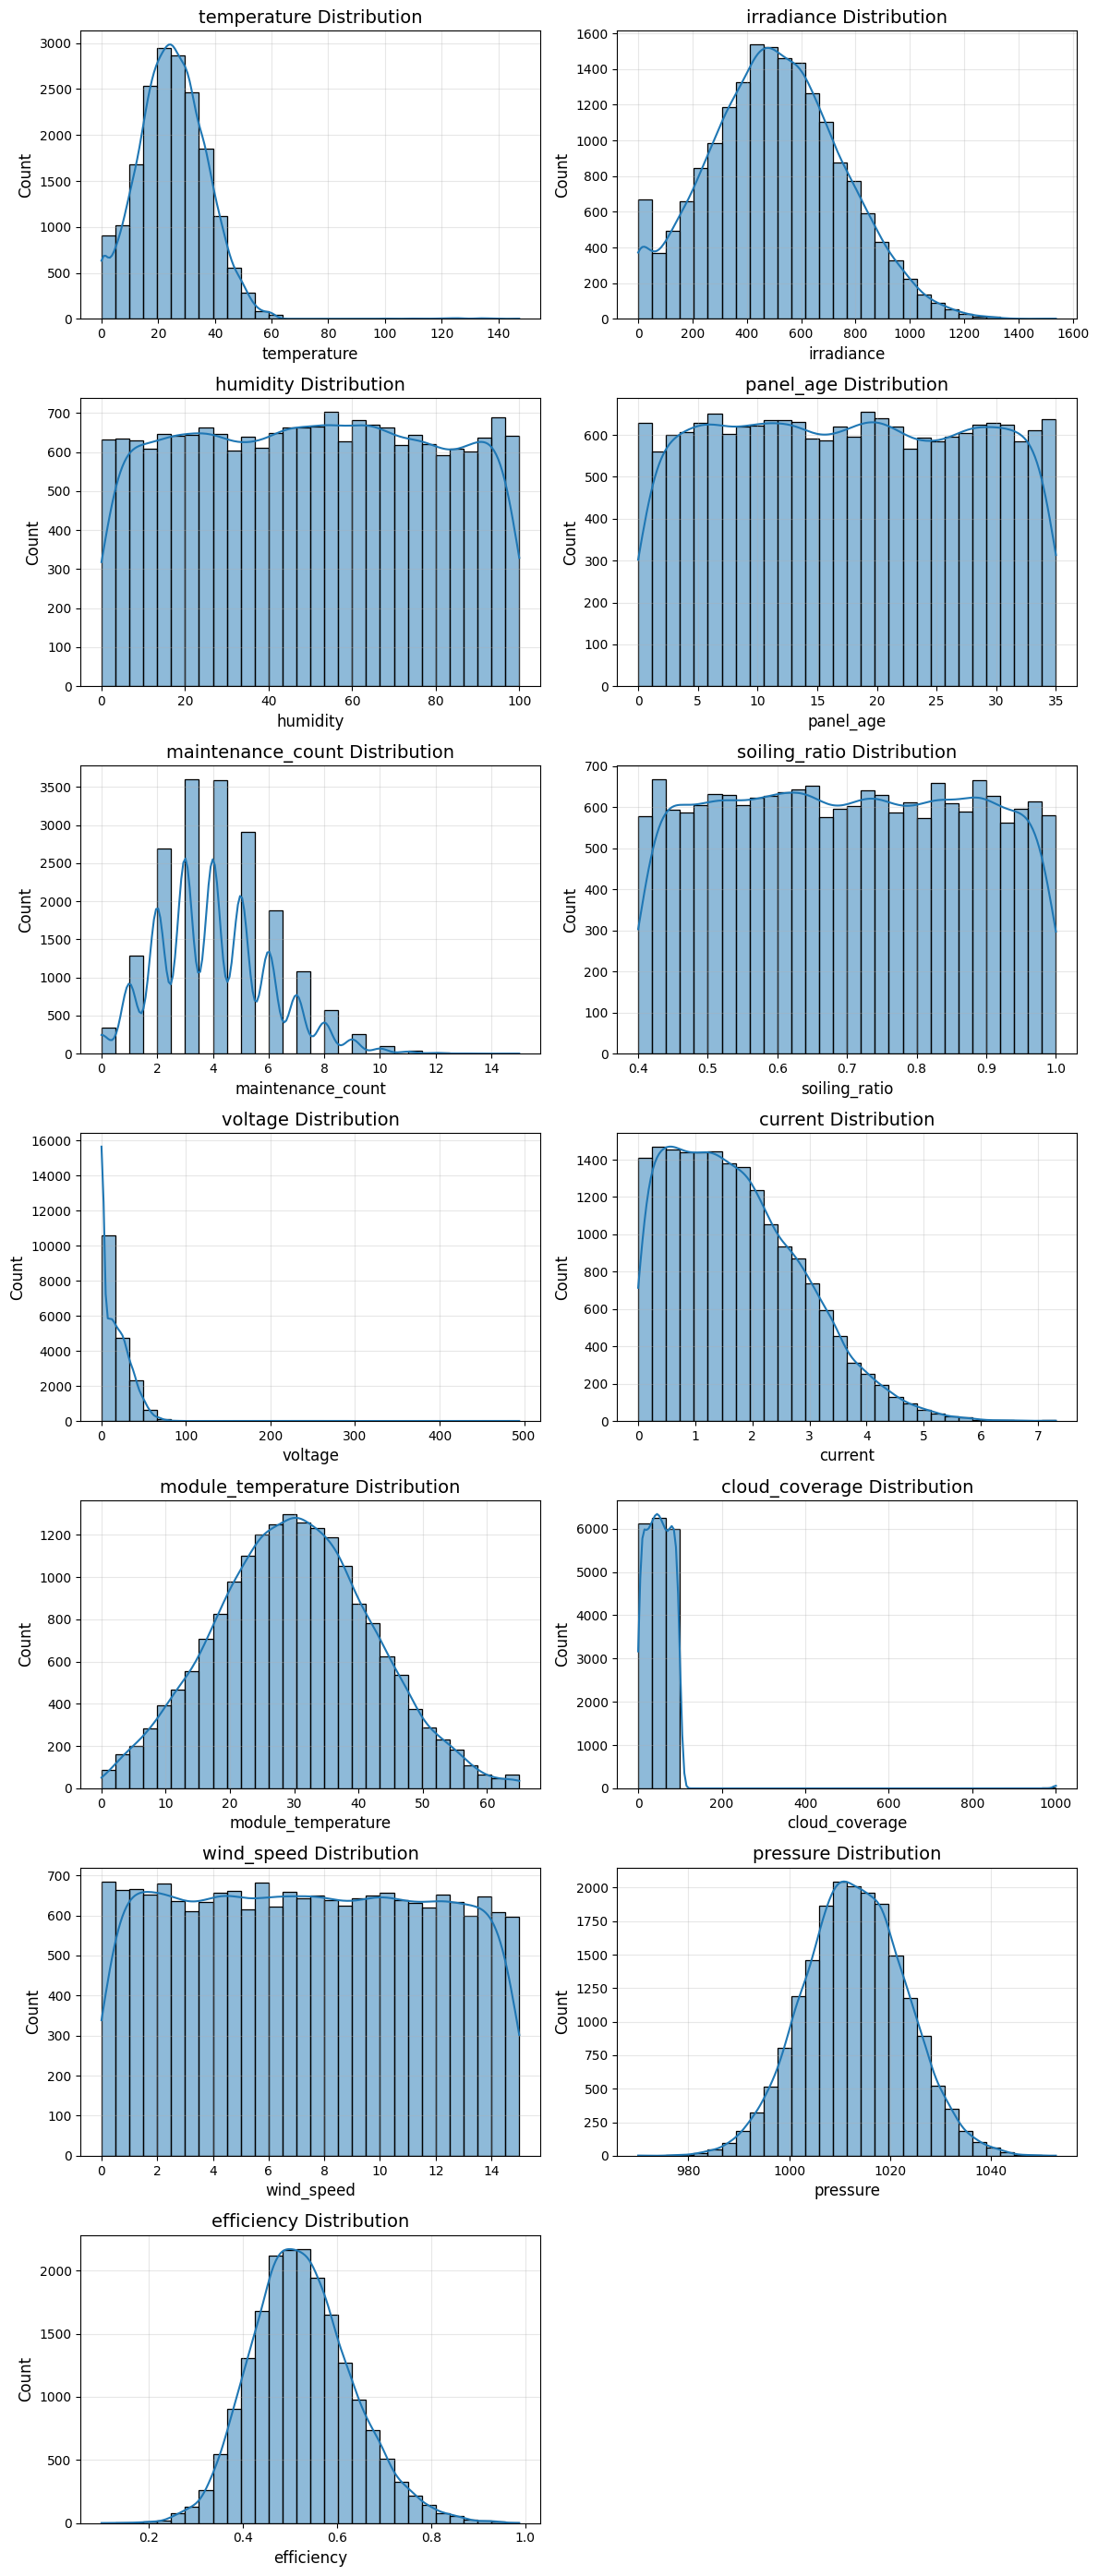

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get all float-type columns
float_columns = filtered_df.select_dtypes(include=['float64', 'float32']).columns

# Set number of subplots based on number of float columns
n_cols = 2  # You can change this based on how many plots you want per row
n_rows = (len(float_columns) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot each float column
for i, col in enumerate(float_columns):
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
filtered_df.describe()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,efficiency
count,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000
mean,9935.252216,24.828806,468.055064,50.039826,17.577163,4.029901,0.698842,12.104866,1.449359,29.847820,49.773981,7.423835,1012.945872,0.514733
std,5755.757684,11.797537,231.834867,28.509326,9.806245,1.948352,0.167301,12.062607,0.892090,11.848200,28.793625,4.321095,10.018161,0.103119
min,0.000000,0.000000,0.000000,0.017622,0.001264,0.000000,0.400266,0.000000,0.000054,0.000000,0.002635,0.001277,970.087365,0.100000
25%,4962.000000,16.769862,305.786973,25.515254,9.388774,3.000000,0.559415,0.000000,0.687866,21.891398,25.011368,3.710949,1006.178867,0.444264
50%,9913.000000,24.632494,467.947466,50.159955,17.534726,4.000000,0.697854,9.279433,1.385043,29.807750,49.512612,7.413883,1012.865863,0.509143
75%,14901.000000,32.787746,626.203358,74.162500,25.912113,5.000000,0.838799,21.492902,2.138800,37.545611,74.793864,11.142112,1019.708397,0.578928
max,19996.000000,60.000000,1191.616521,99.991539,34.998379,15.000000,0.999869,39.415147,3.310861,65.000000,99.995045,14.998279,1048.332323,0.951265


In [20]:
## drop the id ccolumn
ids = filtered_df['id']
filtered_df = filtered_df.drop(columns = ['id'])

# Feature Engineering

One hot encoding categorical features (string_id, error_code and installation_type)

In [ ]:
# Specify the low‐cardinality categorical columns to one‐hot encode
cols_to_encode = ['string_id', 'error_code', 'installation_type']

# Perform one‐hot encoding using pandas.get_dummies
filtered_df_encoded = pd.get_dummies(
    filtered_df,
    columns=cols_to_encode,
    prefix=cols_to_encode,
    drop_first=False  # keep all dummy columns (you can set True to avoid multicollinearity)
)

# View the first few rows of the encoded DataFrame
filtered_df_encoded.head()

,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,efficiency,string_id_A1,string_id_B2,string_id_C3,string_id_D4,error_code_E00,error_code_E01,error_code_E02,error_code_missing,installation_type_dual-axis,installation_type_fixed,installation_type_missing,installation_type_tracking
0,7.817315,576.179270,41.243087,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.824912,1018.866505,0.562096,True,False,False,False,False,False,False,True,False,False,True,False
1,24.785727,240.003973,1.359648,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012044,1025.623854,0.396447,False,False,False,True,True,False,False,False,True,False,False,False
2,5.575374,12.241203,27.495073,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.522684,1008.555958,0.341874,False,True,False,False,True,False,False,False,False,True,False,False
3,16.545541,174.455123,86.116835,29.853202,5.0,0.962880,5.356320,2.878068,19.392300,11.170874,8.541404,1006.957880,0.376127,False,False,True,False,True,False,False,False,False,False,False,True
4,18.728064,531.960101,91.252254,20.672099,4.0,0.911821,0.706348,2.131411,26.521808,31.736361,3.593830,1016.005080,0.537196,True,False,False,False,True,False,False,False,False,True,False,False


New Features:
Power: voltage * current (direct measure of output).

Temperature Delta: module_temperature - temperature (cooling efficiency).

Maintenance Impact: panel_age / (maintenance_count + 1) (normalize maintenance frequency).

Cloud Impact: cloud_coverage * irradiance (effective sunlight).

In [22]:
# Add new derived features
filtered_df_encoded['power'] = filtered_df_encoded['voltage'] * filtered_df_encoded['current']
filtered_df_encoded['temperature_delta'] = filtered_df_encoded['module_temperature'] - filtered_df_encoded['temperature']
filtered_df_encoded['maintenance_impact'] = filtered_df_encoded['panel_age'] / (filtered_df_encoded['maintenance_count'] + 1)
filtered_df_encoded['cloud_impact'] = filtered_df_encoded['cloud_coverage'] * filtered_df_encoded['irradiance']

Make train dataset ready

In [23]:
train = filtered_df_encoded.copy()

# Train the model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Define features and target
X = train.drop(columns=['efficiency'])
y = train['efficiency']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train tree based models

In [25]:
rf_params = {
    'n_estimators': 100,        # Number of trees
    'max_depth': None,          # Maximum depth of each tree
    'min_samples_split': 2,     # Minimum samples to split a node
    'min_samples_leaf': 1,      # Minimum samples at a leaf node
    'max_features': 'auto',     # Features to consider for splits
    'random_state': 42,         # Seed for reproducibility
    'n_jobs': -1               # Use all CPU cores
}

xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,       # L1 regularization
    'reg_lambda': 1,      # L2 regularization
    'random_state': 42,
    'verbosity': 0        # Suppresses training logs
}

lgbm_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': -1,      # -1 = no limit (tree grows until `num_leaves`)
    'num_leaves': 31,     # Maximum leaves per tree
    'subsample': 0.8,     # Random subset of data per iteration
    'colsample_bytree': 0.8,  # Random subset of features per tree
    'reg_alpha': 0.0,     # L1 regularization
    'reg_lambda': 0.0,    # L2 regularization
    'random_state': 42
}

catboost_params = {
    'iterations': 1000,    # Equivalent to n_estimators
    'learning_rate': 0.03,
    'depth': 6,            # Tree depth
    'l2_leaf_reg': 3,      # L2 regularization
    'loss_function': 'RMSE',
    'verbose': 100,        # Prints progress every 100 iterations
    'random_state': 42
}

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

# Train models and collect evaluation metrics
results = []

In [30]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append({
        "Model": name,
        "R2 Score": r2,
        "RMSE": rmse,
        "MAE": mae
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3863
[LightGBM] [Info] Number of data points in the train set: 9658, number of used features: 28
[LightGBM] [Info] Start training from score 0.514585


In [31]:
# Create a results DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,R2 Score,RMSE,MAE
0,Random Forest,0.828812,0.001775,0.033455
1,XGBoost,0.815339,0.001915,0.034767
2,LightGBM,0.832283,0.001739,0.032944
3,CatBoost,0.832452,0.001737,0.033040


In [34]:
import os
import pickle

save_dir = r'C:\Local Disk F\ML\Zelestra ML Challenge\Models'

for name, model in models.items():
    filename = os.path.join(save_dir, f'{name.lower().replace(" ", "_")}_model.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(model, file)